In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
from __future__ import division, print_function
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from keras.layers import *
from keras.models import *
from time import clock
import numpy as np
import os
from IPython.display import clear_output

In [2]:
input_ = Input((None, None, 3), name='image')

def main_block(input_, padding='same'):
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_1', activation='relu')(input_)
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool1_stage1')(x)

    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_1', activation='relu')(x)
    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool2_stage1')(x)

    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_1', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_2', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_3', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_4', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool3_stage1')(x)

    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_2', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_3', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_4', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_2', activation='relu')(x)
    conv5_3_CPM = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv5_3_CPM', activation='relu')(x)
    x = Conv2D(512, (1,1), strides=(1,1), padding='valid', name='conv6_1_CPM', activation='relu')(conv5_3_CPM)
    conv6_2_CPM = Conv2D(22, (1,1), padding='valid', strides=(1,1), name='conv6_2_CPM')(x)
    return conv5_3_CPM, conv6_2_CPM

conv5_3_CPM, conv6_2_CPM = main_block(input_)

def stage_block(conv5_3_CPM, prev_stage, stage, padding='same'):
    x = concatenate([ prev_stage, conv5_3_CPM ], axis=3, name='concat_stage{}'.format(stage))
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv1_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv2_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv3_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv4_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv5_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (1,1), strides=(1,1), padding='valid', name='Mconv6_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(22, (1,1), strides=(1,1), padding='valid', name='Mconv7_stage{}'.format(stage))(x)
    return x
    
prev_stage = conv6_2_CPM
for stage in range(2, 7):
    prev_stage = stage_block(conv5_3_CPM, prev_stage, stage)
    
x = prev_stage
model = Model(input_, x)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 6 1792        image[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, None, None, 6 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1_stage1 (MaxPooling2D)     (None, None, None, 6 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [0]:
# https://drive.google.com/uc?id=1yPQFrCrDltqzYAnWBl__O7oZxGL0sQlu&export=download
model.load_weights('openpose_hand_keras.h5')

In [0]:
def find_peaks(heatmap_avg, thre=0.1, sigma=3):
    all_peaks = []
    peak_counter = 0

    for part in range(0, heatmap_avg.shape[-1]):
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=sigma)
#        plt.imshow(map)
#        plt.show()

        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > thre))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks, peak_counter

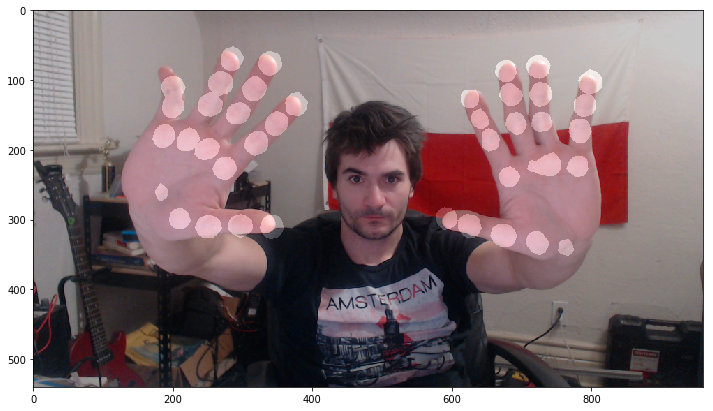

In [25]:
def process_image(model, image_orig, scale_mul=2, peaks_th=0.1, sigma=3, mode='heatmap'):
    
    scale = 368/image_orig.shape[1]
    scale = scale*scale_mul
    image =  cv2.resize(image_orig, (0,0), fx=scale, fy=scale) 

    start = clock()
    net_out = model.predict(np.expand_dims( image /256 -0.5 ,0))
    stop = clock()
    took = stop-start
    
    out = cv2.resize( net_out[0], (image_orig.shape[1], image_orig.shape[0]) )
    image_out = image_orig
    
    mask = np.zeros_like(image_out).astype(np.float32)
    if mode == 'heatmap':
        for chn in range(0, out.shape[-1]-2):
            m = np.repeat(out[:,:,chn:chn+1],3, axis=2)
            m = 255*( np.abs(m)>0.2)
            
            mask = mask + m*(mask==0)
        mask = np.clip(mask, 0, 255)
        image_out = image_out*0.8 + mask*0.2
    else:
        peaksR = find_peaks(out, peaks_th, sigma=sigma)[0]
        peaksL = find_peaks(-out, peaks_th, sigma=sigma)[0]

        print(peaksR)
        for peak in peaksR:
            if(len(peak)):
                peak = peak[0]
                cv2.drawMarker(image_out, (peak[0], peak[1]), (0,255,0), cv2.MARKER_STAR )
                
    image_out = np.clip(image_out, 0, 255).astype(np.uint8)
                
    return image_out, took

image = cv2.cvtColor(cv2.imread('test_image.png'), cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (960, 540))
image_out = process_image(model, image)[0]
plt.figure(figsize=(12,12))
plt.imshow(image_out)
plt.show()

In [0]:
def find(img, out, r = 1, g = 1, b = 1):
  mask = np.zeros_like(img).astype(np.float32)
  for chn in range(0, out.shape[-1]-2):
    m = np.repeat(out[:,:,chn:chn+1],3, axis=2)
    m = 255*( np.abs(m)>0.2)
    m[:,:,0] *= r
    m[:,:,1] *= g
    m[:,:,2] *= b
    mask = mask + m*(mask==0)
  mask = np.clip(mask, 0, 255)
  return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(414, 736, 3)


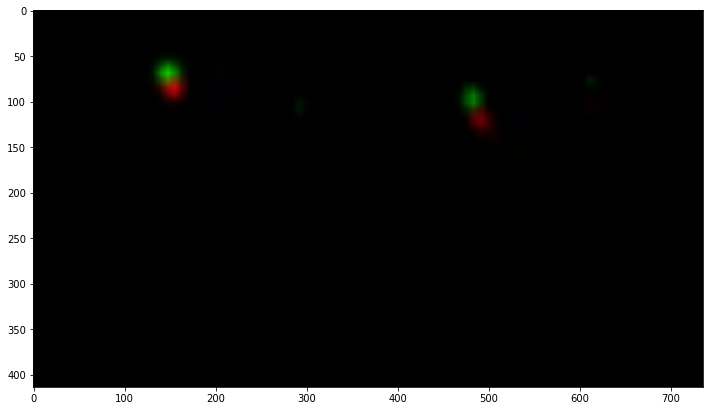

In [86]:
#img = np.array(Image.open('test_image.png').getdata()).reshape(1090,1920,3)

img = cv2.cvtColor(cv2.imread('test_image.png'), cv2.COLOR_BGR2RGB)
img = cv2.resize(image, (960, 540))

scale = 368/img.shape[1]
scale = scale*2
img =  cv2.resize(img, (0,0), fx=scale, fy=scale)

net_out = model.predict(np.expand_dims( img /256 -0.5 ,0))
out = cv2.resize( net_out[0], (img.shape[1], img.shape[0]) )
#print(result)
#print(result.argmax())

mask = np.zeros_like(img).astype(np.float32)
m = find(img,out,r=1,g=1,b=1)
out = out[:,:,19:22]
m2 = find(img,out,r=0,g=1,b=1)

image_out = img*0.8 + m*0.2 + m2*1
image_out /= 255
#image_out = np.clip(image_out, 0, 255).astype(np.uint8)
#out = out[:,:,:3]
print(out.shape)
plt.figure(figsize=(12,12))
plt.imshow(out)
plt.show()